### CMPE 256 Class Presentation - VAR Commodity Pricing Model - Gold & Silver ###
###### Covers: Book Topics: Machine Learning and Artificial Intelligence for Agricultural Economics: Prognostic Data Analytics to Serve Small Scale Farmers Worldwide, Publisher :  Springer; 1st ed. 2021 edition (October 5, 2021), ISBN-13: 978-3030774844 ######

https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

***FORECASTING of Gold and Oil*** have garnered major attention from academics, investors and Government agencies like. These two products are known for their substantial influence on global economy. I will show here, how to use Granger’s Causality Test to test the relationships of multiple variables in the time series and Vector Auto Regressive Model (VAR) to forecast the future Gold & Oil prices from the historical data of ***Gold prices, Silver prices, Crude Oil prices, Stock index , Interest Rate and USD rate***.

https://www.lbma.org.uk/prices-and-data/precious-metal-prices#/
https://fred.stlouisfed.org/series/FEDFUNDS

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random 
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as spstats
import seaborn as sns


%matplotlib inline
mpl.style.reload_library()
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = (1, 1, 1, 0)
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 40

In [2]:
! pip install seaborn

<H1> Gold Dataset </H1> <H3> Load Glod Dataset and set Date as Index. </H3>

In [8]:
#Gold price data
goldDF = pd.read_csv("./Desktop/CMPE-256/Assignments/Assignment-1/lbma_gold_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
goldDF = goldDF.set_index('Date')
goldDF.head()


/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '12/31/2021' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '12/30/2021' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '12/29/2021' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '12/24/2021' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.


GoldPrice
Date                 
2022-03-31    1924.10
2022-03-30    1917.80
2022-03-29    1911.05
2022-03-28    1927.00
2022-03-25    1956.65

<h3> Check for nulls </H3>

In [9]:
goldDF.isnull().sum() ## missing values

GoldPrice    0
dtype: int64

In [10]:
goldDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13712 entries, 2022-03-31 to 1968-02-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GoldPrice  13712 non-null  float64
dtypes: float64(1)
memory usage: 214.2 KB


In [11]:
goldDF.columns

Index(['GoldPrice'], dtype='object')

Text(0, 0.5, 'Frequency')

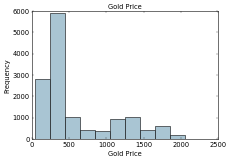

In [12]:
 
fig, ax = plt.subplots()
goldDF['GoldPrice'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('Gold Price', fontsize=12)
ax.set_xlabel('Gold Price', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

<h5> Create Gold Price Bins - divide price into five quantiles (0, 25%, 50%, 75%, and 100%) </h5>

In [13]:
goldDF['GoldPrice_bin_round'] = np.array(np.floor(
                              np.array(goldDF['GoldPrice']) / 10.))
goldDF[['GoldPrice', 'GoldPrice_bin_round']].iloc[1071:2076]

GoldPrice  GoldPrice_bin_round
Date                                      
2018-08-01    1318.80                131.0
2018-05-01    1317.90                131.0
2018-04-01    1313.70                131.0
2018-03-01    1314.60                131.0
2018-02-01    1312.80                131.0
...               ...                  ...
2014-01-23    1244.25                124.0
2014-01-22    1239.50                123.0
2014-01-21    1247.75                124.0
2014-01-20    1254.75                125.0
2014-01-17    1241.00                124.0

[1005 rows x 2 columns]

In [14]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = goldDF['GoldPrice'].quantile(quantile_list)
quantiles

0.00      34.780
0.25     281.775
0.50     384.000
0.75     892.250
1.00    2061.500
Name: GoldPrice, dtype: float64

Text(0, 0.5, 'Frequency')

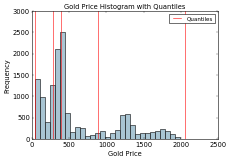

In [15]:
fig, ax = plt.subplots()
goldDF['GoldPrice'].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Gold Price Histogram with Quantiles', 
             fontsize=12)
ax.set_xlabel('Gold Price', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [16]:
goldDF['GoldPrice_log'] = np.log((1+ goldDF['GoldPrice']))
goldDF[[ 'GoldPrice', 'GoldPrice_log']].iloc[4:9]

GoldPrice  GoldPrice_log
Date                                
2022-03-25    1956.65       7.579500
2022-03-24    1945.90       7.573994
2022-03-23    1932.15       7.566906
2022-03-22    1929.35       7.565457
2022-03-21    1925.05       7.563227

Text(11.5, 450, '$\\mu$=5.96')

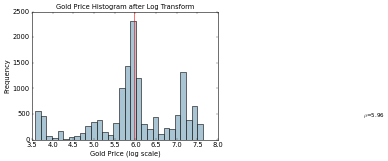

In [17]:
goldprice_log_mean = np.round(np.mean(goldDF['GoldPrice_log']), 2)
fig, ax = plt.subplots()
goldDF['GoldPrice_log'].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
plt.axvline(goldprice_log_mean, color='r')
ax.set_title('Gold Price Histogram after Log Transform', 
             fontsize=12)
ax.set_xlabel('Gold Price (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(goldprice_log_mean), fontsize=10)

In [18]:
goldprice = np.array(goldDF['GoldPrice'])
goldprice_clean = goldprice[~np.isnan(goldprice)]
l, opt_lambda = spstats.boxcox(goldprice_clean)
print('Optimal lambda value:', opt_lambda)

Optimal lambda value: 0.22789603130062897


In [19]:
goldDF['goldprice_boxcox_lambda_0'] = spstats.boxcox(
                                        (1+goldDF['GoldPrice']), 
                                          lmbda=0)
goldDF['goldprice_boxcox_lambda_opt'] = spstats.boxcox(
                                            goldDF['GoldPrice'], 
                                              lmbda=opt_lambda)

goldDF[['GoldPrice', 'GoldPrice_log', 
               'goldprice_boxcox_lambda_0',       
               'goldprice_boxcox_lambda_opt']].iloc[4:9]

GoldPrice  GoldPrice_log  goldprice_boxcox_lambda_0  \
Date                                                              
2022-03-25    1956.65       7.579500                   7.579500   
2022-03-24    1945.90       7.573994                   7.573994   
2022-03-23    1932.15       7.566906                   7.566906   
2022-03-22    1929.35       7.565457                   7.565457   
2022-03-21    1925.05       7.563227                   7.563227   

            goldprice_boxcox_lambda_opt  
Date                                     
2022-03-25                    20.294357  
2022-03-24                    20.263387  
2022-03-23                    20.223581  
2022-03-22                    20.215448  
2022-03-21                    20.202941

Text(24, 450, '$\\mu$=13.11')

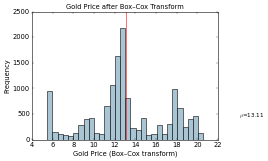

In [20]:
goldprice_boxcox_mean = np.round(
                      np.mean(
                       goldDF['goldprice_boxcox_lambda_opt']),2)
fig, ax = plt.subplots()
goldDF['goldprice_boxcox_lambda_opt'].hist(bins=30, 
                     color='#A9C5D3', edgecolor='black', grid=False)
plt.axvline(goldprice_boxcox_mean, color='r')
ax.set_title('Gold Price after Box–Cox Transform', 
             fontsize=12)
ax.set_xlabel('Gold Price (Box–Cox transform)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(24, 450, r'$\mu$='+str(goldprice_boxcox_mean), fontsize=10)

In [25]:
#Silver price data
silverDF = pd.read_csv("./Desktop/CMPE-256/Assignments/Assignment-1/lbma_silver_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
silverDF = silverDF.set_index('Date')
silverDF.head()


/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '12/31/2021' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '12/30/2021' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '12/29/2021' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '12/24/2021' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.


SilverPrice
Date                   
2022-03-31       24.815
2022-03-30       24.755
2022-03-29       24.640
2022-03-28       24.905
2022-03-25       25.620

In [26]:
silverDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13723 entries, 2022-03-31 to 1968-02-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SilverPrice  13704 non-null  float64
dtypes: float64(1)
memory usage: 214.4 KB


In [27]:
silverDF.isnull().sum() ## missing values

SilverPrice    19
dtype: int64

In [28]:
mean_imputation_silverDF = silverDF.copy()
mean_imputation_silverDF['SilverPrice_Mean_Filled'] = mean_imputation_silverDF['SilverPrice'].fillna(silverDF['SilverPrice'].mean())

In [29]:
silverDF.SilverPrice.describe().T

count    13704.000000
mean         9.852661
std          7.993719
min          1.272000
25%          4.615000
50%          5.985500
75%         14.820000
max         49.450000
Name: SilverPrice, dtype: float64

In [30]:
mean_imputation_silverDF.SilverPrice.describe().T

count    13704.000000
mean         9.852661
std          7.993719
min          1.272000
25%          4.615000
50%          5.985500
75%         14.820000
max         49.450000
Name: SilverPrice, dtype: float64

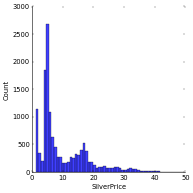

In [31]:
sns.displot(silverDF, x="SilverPrice")

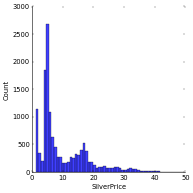

In [32]:
sns.displot(mean_imputation_silverDF, x="SilverPrice")

In [33]:
silverDF['SilverPrice_log'] = np.log((1+ silverDF['SilverPrice']))
silverDF[[ 'SilverPrice', 'SilverPrice_log']].iloc[4:9]

SilverPrice  SilverPrice_log
Date                                    
2022-03-25       25.620         3.281663
2022-03-24       25.315         3.270139
2022-03-23       25.015         3.258673
2022-03-22       25.085         3.261360
2022-03-21       25.035         3.259442

Text(11.5, 450, '$\\mu$=2.15')

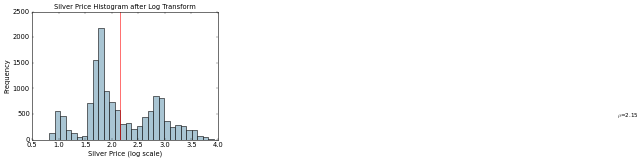

In [34]:

silverprice_log_mean = np.round(np.mean(silverDF['SilverPrice_log']), 2)
fig, ax = plt.subplots()
silverDF['SilverPrice_log'].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
plt.axvline(silverprice_log_mean, color='r')
ax.set_title('Silver Price Histogram after Log Transform', 
             fontsize=12)
ax.set_xlabel('Silver Price (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(silverprice_log_mean), fontsize=10)

In [35]:
! pip install impyute

In [36]:
# silverDF

In [38]:
# USD Index
# Trade Weighted U.S. Dollar Index: Broad, Goods and Services (DTWEXBGS)
# https://fred.stlouisfed.org/series/DTWEXBGS 
usdFedFundsDF = pd.read_csv("./Desktop/CMPE-256/Assignments/Assignment-1/FEDFUNDS_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)


usdFedFundsDF = usdFedFundsDF.set_index('Date')

usdFedFundsDF.head() 

FEDFUNDS
Date                
1954-01-07      0.80
1954-01-08      1.22
1954-01-09      1.07
1954-01-10      0.85
1954-01-11      0.83

In [39]:
usdFedFundsDF.tail(10)

FEDFUNDS
Date                
2021-01-06      0.08
2021-01-07      0.10
2021-01-08      0.09
2021-01-09      0.08
2021-01-10      0.08
2021-01-11      0.08
2021-01-12      0.08
2022-01-01      0.08
2022-01-02      0.08
2022-01-03      0.20

In [40]:
usdFedFundsDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813 entries, 1954-01-07 to 2022-01-03
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FEDFUNDS  813 non-null    float64
dtypes: float64(1)
memory usage: 12.7 KB


In [41]:
usdFedFundsDF.isnull().sum() ## missing values

FEDFUNDS    0
dtype: int64

In [43]:
# Interest
# 10-Year Treasury Constant Maturity Rate (DGS10)
# https://fred.stlouisfed.org/series/DGS10

### https://fred.stlouisfed.org/series/FEDFUNDS
interestRateDF = pd.read_csv("./Desktop/CMPE-256/Assignments/Assignment-1/DGS10.csv",parse_dates=['DATE'], dayfirst=True)
interestRateDF = interestRateDF.rename(columns={"DATE":'Date'})

interestRateDF = interestRateDF.set_index('Date')

interestRateDF.head() 

DGS10
Date            
1962-01-02  4.06
1962-01-03  4.03
1962-01-04  3.99
1962-01-05  4.02
1962-01-08  4.03

In [44]:
interestRateDF.tail(10)

DGS10
Date            
2022-04-06  2.61
2022-04-07  2.66
2022-04-08  2.72
2022-04-11  2.79
2022-04-12  2.72
2022-04-13  2.70
2022-04-14  2.83
2022-04-15     .
2022-04-18  2.85
2022-04-19  2.93

In [45]:
interestRateDF['DGS10'] = interestRateDF['DGS10'].replace('.',np.nan)

In [46]:
interestRateDF.isnull().sum() ## missing values

DGS10    671
dtype: int64

In [47]:
interestRateDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15731 entries, 1962-01-02 to 2022-04-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DGS10   15060 non-null  object
dtypes: object(1)
memory usage: 245.8+ KB


In [48]:
interestRateDF.isnull().sum() ## missing values

DGS10    671
dtype: int64

In [50]:
# S&P Index
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1611360000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=-628819200&period2=1650412800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
spindex500Index = pd.read_csv("./Desktop/CMPE-256/Assignments/Assignment-1/SPIndex_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)

spindex500Index = spindex500Index.set_index('Date')

spindex500Index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14100 entries, 2022-04-19 to 2066-04-14
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Open         14100 non-null  object
 1   High         14100 non-null  object
 2   Low          14100 non-null  object
 3   Close*       14100 non-null  object
 4   Adj Close**  14100 non-null  object
 5   Volume       14100 non-null  object
dtypes: object(6)
memory usage: 771.1+ KB


In [51]:
spindex500Index.isnull().sum() ## missing values

Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

In [52]:
spindex500Index.columns

Index(['Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

In [53]:

spindex500Index = spindex500Index.drop('Open', 1)
spindex500Index = spindex500Index.drop('High', 1)
spindex500Index = spindex500Index.drop('Low', 1)
spindex500Index = spindex500Index.drop('Close*', 1)
spindex500Index = spindex500Index.drop('Volume', 1)

/var/folders/3m/l7h25c9d0mj46kv1xkbdmb0c0000gr/T/ipykernel_59553/3432906392.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  spindex500Index = spindex500Index.drop('Open', 1)
/var/folders/3m/l7h25c9d0mj46kv1xkbdmb0c0000gr/T/ipykernel_59553/3432906392.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  spindex500Index = spindex500Index.drop('High', 1)
/var/folders/3m/l7h25c9d0mj46kv1xkbdmb0c0000gr/T/ipykernel_59553/3432906392.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  spindex500Index = spindex500Index.drop('Low', 1)
/var/folders/3m/l7h25c9d0mj46kv1xkbdmb0c0000gr/T/ipykernel_59553/3432906392.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be key

In [54]:



spindex500Index= spindex500Index.rename(columns={'Adj Close**':'AdjClose'})


In [55]:
spindex500Index['AdjClose'] = spindex500Index['AdjClose'].replace(',', '')

In [56]:
spindex500Index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14100 entries, 2022-04-19 to 2066-04-14
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AdjClose  14100 non-null  object
dtypes: object(1)
memory usage: 220.3+ KB


In [57]:
#spindex500Index

In [58]:
spindex500Index=spindex500Index.loc['19720101':'20220419']
#spindex500Index

/var/folders/3m/l7h25c9d0mj46kv1xkbdmb0c0000gr/T/ipykernel_59553/1040507573.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  spindex500Index=spindex500Index.loc['19720101':'20220419']


In [60]:
# Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma
# https://fred.stlouisfed.org/series/DCOILWTICO
oilPricesDF = pd.read_csv("./Desktop/CMPE-256/Assignments/Assignment-1/DCOILWTICO_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
oilPricesDF = oilPricesDF.set_index('Date')
oilPricesDF.head()

/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '10/13/1986' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '10/14/1986' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '10/15/1986' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '10/16/1986' in MM/DD/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.


CrudeOilPrices(WTI)
Date                          
1986-02-01               25.56
1986-03-01                  26
1986-06-01               26.53
1986-07-01               25.85
1986-08-01               25.87

In [61]:
oilPricesDF['CrudeOilPrices(WTI)'] = oilPricesDF['CrudeOilPrices(WTI)'].replace('.',np.nan)

In [62]:
oilPricesDF.isnull().sum() ## missing values

CrudeOilPrices(WTI)    323
dtype: int64

In [63]:
oilPricesDF['CrudeOilPrices(WTI)']

Date
1986-02-01     25.56
1986-03-01        26
1986-06-01     26.53
1986-07-01     25.85
1986-08-01     25.87
               ...  
2022-12-04    100.52
2022-04-13    104.26
2022-04-14    106.84
2022-04-15       NaN
2022-04-18    108.24
Name: CrudeOilPrices(WTI), Length: 9468, dtype: object

### Exploratory analysis: ###

Let’s load the data and do some analysis with visualization to know insights of the data. Exploratory data analysis is quite extensive in multivariate time series. I will cover some areas here to get insights of the data. However, it is advisable to conduct all statistical tests to ensure our clear understanding on data distribution.

In [64]:
oilPricesDF.columns
### https://stackoverflow.com/questions/46834732/convert-pandas-datetime-column-yyyy-mm-dd-to-yyyymmdd
## https://datatofish.com/strings-to-datetime-pandas/

Index(['CrudeOilPrices(WTI)'], dtype='object')

In [65]:
pd.set_option('display.max_rows', None)
dataset = pd.concat([goldDF,silverDF,oilPricesDF,usdFedFundsDF,interestRateDF,spindex500Index], axis=1)
print('Number of colums in Dataframe : ', len(dataset.columns))
print('Number of rows in Dataframe : ', len(dataset.index))
print(dataset)

Number of colums in Dataframe :  11
Number of rows in Dataframe :  17460


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17460 entries, 1954-01-07 to 2022-12-04
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   GoldPrice                    13712 non-null  float64
 1   GoldPrice_bin_round          13712 non-null  float64
 2   GoldPrice_log                13712 non-null  float64
 3   goldprice_boxcox_lambda_0    13712 non-null  float64
 4   goldprice_boxcox_lambda_opt  13712 non-null  float64
 5   SilverPrice                  13704 non-null  float64
 6   SilverPrice_log              13704 non-null  float64
 7   CrudeOilPrices(WTI)          9145 non-null   object 
 8   FEDFUNDS                     813 non-null    float64
 9   DGS10                        15060 non-null  object 
 10  AdjClose                     12685 non-null  object 
dtypes: float64(8), object(3)
memory usage: 1.6+ MB


In [67]:
dataset.drop(['GoldPrice_bin_round','GoldPrice_log','goldprice_boxcox_lambda_0','goldprice_boxcox_lambda_opt','SilverPrice_log'], axis = 1, inplace = True, errors = 'ignore')

***Let’s fix the dates for all the series.***

In [68]:
# dataset

In [69]:
dataset.tail()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS DGS10  \
Date                                                                     
2022-11-02    1826.25       22.895                93.1       NaN   NaN   
2022-11-03    1991.45       25.655              109.31       NaN   NaN   
2022-11-04        NaN          NaN               94.22       NaN   NaN   
2022-12-01    1816.40       22.745               82.51       NaN   NaN   
2022-12-04        NaN          NaN              100.52       NaN   NaN   

           AdjClose  
Date                 
2022-11-02      NaN  
2022-11-03      NaN  
2022-11-04      NaN  
2022-12-01      NaN  
2022-12-04      NaN

In [70]:
### dataset=dataset.loc['20100101':'20200824']
dataset=dataset.loc['20000101':'20220301']
dataset.head()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS DGS10  \
Date                                                                     
2000-01-01        NaN          NaN                 NaN      5.45   NaN   
2000-01-02     283.65        5.243               28.28      5.73   NaN   
2000-01-03     293.75        5.125               31.71      5.85  6.58   
2000-01-04        NaN          NaN                 NaN      6.02  6.49   
2000-01-05        NaN          NaN               25.84      6.27  6.62   

            AdjClose  
Date                  
2000-01-01       NaN  
2000-01-02       NaN  
2000-01-03  1,455.22  
2000-01-04  1,399.42  
2000-01-05  1,402.11

In [71]:
dataset.tail()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS DGS10  \
Date                                                                     
2022-02-23    1895.70       24.105               92.14       NaN  1.99   
2022-02-24    1968.35       25.315               92.77       NaN  1.96   
2022-02-25    1912.15       24.210               91.68       NaN  1.97   
2022-02-28    1903.30       24.350               96.13       NaN  1.83   
2022-03-01        NaN          NaN               75.99       NaN  1.72   

            AdjClose  
Date                  
2022-02-23  4,225.50  
2022-02-24  4,288.70  
2022-02-25  4,384.65  
2022-02-28  4,373.94  
2022-03-01  4,306.26

In [72]:
dataset.isnull().sum() ## missing values

GoldPrice               848
SilverPrice             848
CrudeOilPrices(WTI)     887
FEDFUNDS               6170
DGS10                   893
AdjClose                861
dtype: int64

In [73]:
# https://stackoverflow.com/questions/31170550/pandas-df-fillnamethod-pad-not-working-on-28000-row-df

dataset=dataset.fillna(method='pad') 
dataset = dataset.fillna(method = 'bfill')

In [74]:
dataset.isnull().sum() ## missing values

GoldPrice              0
SilverPrice            0
CrudeOilPrices(WTI)    0
FEDFUNDS               0
DGS10                  0
AdjClose               0
dtype: int64

In [75]:
dataset=dataset.dropna()
dataset.head()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS DGS10  \
Date                                                                     
2000-01-01     283.65        5.243               28.28      5.45  6.58   
2000-01-02     283.65        5.243               28.28      5.73  6.58   
2000-01-03     293.75        5.125               31.71      5.85  6.58   
2000-01-04     293.75        5.125               31.71      6.02  6.49   
2000-01-05     293.75        5.125               25.84      6.27  6.62   

            AdjClose  
Date                  
2000-01-01  1,455.22  
2000-01-02  1,455.22  
2000-01-03  1,455.22  
2000-01-04  1,399.42  
2000-01-05  1,402.11

In [76]:
#print(dataset)

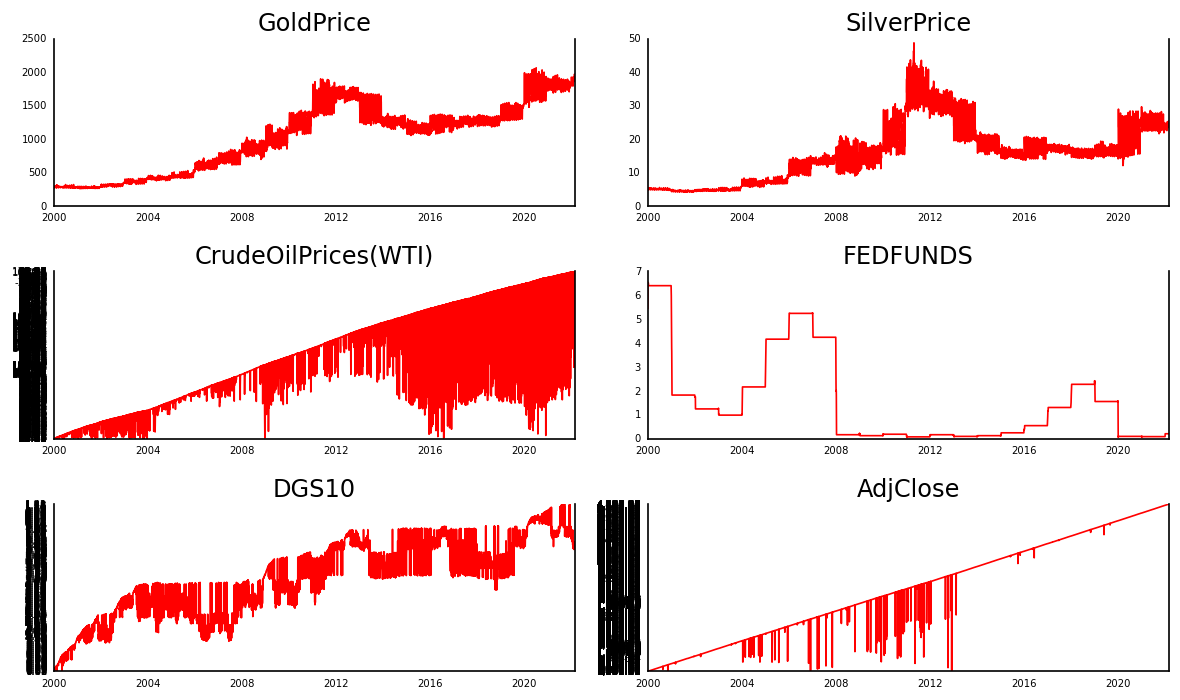

In [77]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
 data = dataset[dataset.columns[i]]
 ax.plot(data, color='red', linewidth=1)
 ax.set_title(dataset.columns[i])
 ax.xaxis.set_ticks_position('none')
 ax.yaxis.set_ticks_position('none')
 ax.spines["top"].set_alpha(0)
 ax.tick_params(labelsize=6)
plt.tight_layout();

***From the above plots, we can visible conclude that, all the series contain unit root with stochastic trend showing a systematic pattern that is unpredictable.***

### Normality Test ###
To extract maximum information from our data, it is important to have a ***normal or Gaussian distribution*** of the data. 
To check for that, we have done a normality test based on the Null and Alternate Hypothesis intuition.


In [78]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6437 entries, 2000-01-01 to 2022-03-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            6437 non-null   float64
 1   SilverPrice          6437 non-null   float64
 2   CrudeOilPrices(WTI)  6437 non-null   object 
 3   FEDFUNDS             6437 non-null   float64
 4   DGS10                6437 non-null   object 
 5   AdjClose             6437 non-null   object 
dtypes: float64(3), object(3)
memory usage: 352.0+ KB


In [79]:
itemcost='1,455.22'
itemcostProc=itemcost.replace(',','')
print(itemcostProc)
print(float(itemcostProc))

1455.22
1455.22


In [80]:
dataset['AdjClose']= dataset['AdjClose'].apply(lambda x: x.replace(',',''))

In [81]:
dataset['AdjClose']

Date
2000-01-01    1455.22
2000-01-02    1455.22
2000-01-03    1455.22
2000-01-04    1399.42
2000-01-05    1402.11
2000-01-06    1403.45
2000-01-07    1441.47
2000-01-08    1441.47
2000-01-09    1441.47
2000-01-10    1457.60
2000-01-11    1438.56
2000-01-12    1432.25
2000-01-13    1449.68
2000-01-14    1465.15
2000-01-17    1465.15
2000-01-18    1455.14
2000-01-19    1455.90
2000-01-20    1445.57
2000-01-21    1441.36
2000-01-24    1401.53
2000-01-25    1410.03
2000-01-26    1404.09
2000-01-27    1398.56
2000-01-28    1360.16
2000-01-31    1394.46
2000-02-01    1409.28
2000-02-02    1409.12
2000-02-03    1424.97
2000-02-04    1424.37
2000-02-05    1424.37
2000-02-06    1424.37
2000-02-07    1424.24
2000-02-08    1441.72
2000-02-09    1411.71
2000-02-10    1416.83
2000-02-11    1387.12
2000-02-14    1389.94
2000-02-15    1402.05
2000-02-16    1387.67
2000-02-17    1388.26
2000-02-18    1346.09
2000-02-21    1346.09
2000-02-22    1352.17
2000-02-23    1360.69
2000-02-24    1353.43
2000-

In [82]:
dataset['CrudeOilPrices(WTI)'] = dataset['CrudeOilPrices(WTI)'].astype('float64')
dataset['CrudeOilPrices(WTI)'] = dataset['CrudeOilPrices(WTI)'].astype('float64')
dataset['DGS10'] = dataset['DGS10'].astype('float64')
dataset['AdjClose'] = dataset['AdjClose'].astype('float64')
dataset.dtypes

GoldPrice              float64
SilverPrice            float64
CrudeOilPrices(WTI)    float64
FEDFUNDS               float64
DGS10                  float64
AdjClose               float64
dtype: object

In [83]:
dataset['CrudeOilPrices(WTI)']

Date
2000-01-01     28.28
2000-01-02     28.28
2000-01-03     31.71
2000-01-04     31.71
2000-01-05     25.84
2000-01-06     30.19
2000-01-07     30.19
2000-01-08     27.85
2000-01-09     33.42
2000-01-10     33.42
2000-01-11     33.14
2000-01-12     32.06
2000-01-13     26.63
2000-01-14     28.01
2000-01-17     28.01
2000-01-18     28.98
2000-01-19     29.11
2000-01-20     29.67
2000-01-21     29.71
2000-01-24     29.25
2000-01-25     30.28
2000-01-26     27.66
2000-01-27     27.22
2000-01-28     27.27
2000-01-31     27.65
2000-02-01     27.65
2000-02-02     27.52
2000-02-03     31.51
2000-02-04     31.51
2000-02-05     26.86
2000-02-06     30.34
2000-02-07     30.34
2000-02-08     28.27
2000-02-09     28.27
2000-02-10     32.05
2000-02-11     32.59
2000-02-14     30.30
2000-02-15     30.17
2000-02-16     30.01
2000-02-17     29.37
2000-02-18     29.51
2000-02-21     29.51
2000-02-22     29.63
2000-02-23     30.19
2000-02-24     30.23
2000-02-25     30.34
2000-02-28     30.11
2000-02-

In [84]:
from scipy import stats

GoldPrice=dataset.GoldPrice.values
print(GoldPrice)


stat,p = stats.normaltest(GoldPrice)

print("GoldPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')


[ 283.65  283.65  293.75 ... 1912.15 1903.3  1903.3 ]
GoldPrice Statistics = 10532.947, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [85]:
from scipy import stats

SilverPrice=dataset.SilverPrice.values
print(SilverPrice)


stat,p = stats.normaltest(SilverPrice)

print("SilverPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')


[ 5.243  5.243  5.125 ... 24.21  24.35  24.35 ]
SilverPrice Statistics = 370.994, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [86]:
from scipy import stats

OilPrice=dataset['CrudeOilPrices(WTI)'].values
print(OilPrice)


stat,p = stats.normaltest(OilPrice)

print("OilPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

[28.28 28.28 31.71 ... 91.68 96.13 75.99]
OilPrice Statistics = 375.902, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [87]:
from scipy import stats

FEDFUNDS=dataset.FEDFUNDS.values
print(FEDFUNDS)


stat,p = stats.normaltest(FEDFUNDS)

print("FEDFUNDS Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

[5.45 5.73 5.85 ... 0.2  0.2  0.2 ]
FEDFUNDS Statistics = 1222.581, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [88]:
from scipy import stats

InterestRate=dataset.DGS10.values
print(InterestRate)


stat,p = stats.normaltest(InterestRate)

print("InterestRate Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

[6.58 6.58 6.58 ... 1.97 1.83 1.72]
InterestRate Statistics = 546.323, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [89]:
dataset.describe()

GoldPrice  SilverPrice  CrudeOilPrices(WTI)    FEDFUNDS        DGS10  \
count  6437.000000  6437.000000          6437.000000  6437.00000  6437.000000   
mean   1016.499759    15.684237            61.214174     1.51414     3.220492   
std     510.296941     8.546880            25.724638     1.83803     1.356238   
min     256.700000     4.065000           -36.980000     0.05000     0.520000   
25%     438.250000     7.360000            40.570000     0.12000     2.110000   
50%    1172.000000    15.770000            58.400000     0.65000     2.990000   
75%    1346.850000    19.500000            80.300000     2.16000     4.290000   
max    2061.500000    48.700000           145.310000     6.54000     6.790000   

          AdjClose  
count  6437.000000  
mean   1790.284097  
std     882.617880  
min     676.530000  
25%    1175.430000  
50%    1411.130000  
75%    2139.760000  
max    4796.560000

In [90]:
weekly_data = dataset.resample('W').mean()

In [91]:
#weekly_data

In [92]:
monthly_data = dataset.resample('M').mean()

In [93]:
#monthly_data

In [94]:
# Plot
# Takes long time 
# fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
# for i, ax in enumerate(axes.flatten()):
#  data = monthly_data[monthly_data.columns[i]]
#  ax.plot(data, color='red', linewidth=1)
#  ax.set_title(monthly_data.columns[i])
#  ax.xaxis.set_ticks_position('none')
#  ax.yaxis.set_ticks_position('none')
#  ax.spines["top"].set_alpha(0)
#  ax.tick_params(labelsize=6)
# plt.tight_layout();

In [95]:
yearly_data = dataset.resample('Y').mean()

In [96]:
yearly_data

GoldPrice  SilverPrice  CrudeOilPrices(WTI)  FEDFUNDS     DGS10  \
Date                                                                            
2000-12-31   279.416835     4.959566            30.268788  6.393367  6.031751   
2001-12-31   271.100347     4.371413            25.964792  1.906146  5.018090   
2002-12-31   309.820819     4.602167            26.129386  1.257474  4.606894   
2003-12-31   363.119792     4.873753            31.053056  0.986146  4.017188   
2004-12-31   409.342637     6.664041            41.346918  2.126678  4.275993   
2005-12-31   443.701370     7.284983            56.400925  4.121096  4.285890   
2006-12-31   604.562755    11.551119            66.215612  5.228741  4.792449   
2007-12-31   694.397743    13.361701            72.077535  4.272465  4.631424   
2008-12-31   873.075521    15.019601           100.008021  0.233646  3.668611   
2009-12-31   971.570934    14.625893            61.555986  0.121661  3.251073   
2010-12-31  1224.228966    20.098483            79.528069  0.179793  3.219207   
2011-12-31  1569.541781    35.275034            95.071096  0.071301  2.795582   
2012-12-31  1667.072300    31.095819            94.191289  0.159164  1.800070   
2013-12-31  1411.302901    23.826980            97.956689  0.090717  2.352765   
2014-12-31  1265.137500    19.072899            93.312569  0.118715  2.544306   
2015-12-31  1160.131661    15.679827            48.808858  0.235536  2.139135   
2016-12-31  1249.073356    17.087855            43.124083  0.533979  1.840277   
2017-12-31  1256.802211    17.050170            50.728810  1.287823  2.330850   
2018-12-31  1270.131250    15.738785            65.009653  2.251736  2.906944   
2019-12-31  1392.179010    16.193089            56.904403  1.574915  2.137270   
2020-12-31  1767.958935    20.494622            39.435326  0.101787  0.901478   
2021-12-31  1798.932241    25.165034            67.908759  0.080000  1.440345   
2022-12-31  1874.004545    24.003182            93.833409  0.194545  1.829318   

               AdjClose  
Date                     
2000-12-31  1429.412694  
2001-12-31  1195.216146  
2002-12-31   994.668294  
2003-12-31   963.770764  
2004-12-31  1131.035959  
2005-12-31  1207.248185  
2006-12-31  1309.736497  
2007-12-31  1475.739688  
2008-12-31  1220.041042  
2009-12-31   946.017785  
2010-12-31  1139.542000  
2011-12-31  1268.887466  
2012-12-31  1377.607387  
2013-12-31  1642.874983  
2014-12-31  1929.792604  
2015-12-31  2060.535986  
2016-12-31  2093.085121  
2017-12-31  2447.057959  
2018-12-31  2744.560139  
2019-12-31  2910.463584  
2020-12-31  3216.206598  
2021-12-31  4267.642276  
2022-12-31  4513.870000

In [ ]:
# Plot
# Takes long time 
# fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
# for i, ax in enumerate(axes.flatten()):
#  data = yearly_data[yearly_data.columns[i]]
#  ax.plot(data, color='red', linewidth=1)
#  ax.set_title(yearly_data.columns[i])
#  ax.xaxis.set_ticks_position('none')
#  ax.yaxis.set_ticks_position('none')
#  ax.spines["top"].set_alpha(0)
#  ax.tick_params(labelsize=6)
# plt.tight_layout();

Gold: Kurtosis of normal distribution: -1.2585665356775937
Gold:Skewness of normal distribution: -0.06973520340255998


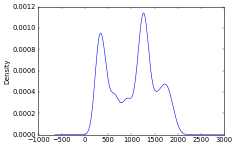

In [97]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.GoldPrice.plot(kind = 'density')  

print('Gold: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.GoldPrice)))
print('Gold:Skewness of normal distribution: {}'.format(stats.skew(dataset.GoldPrice)))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -0.18. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

Silver: Kurtosis of normal distribution: 0.12458851244248415
Silver:Skewness of normal distribution: 0.6352652366712542


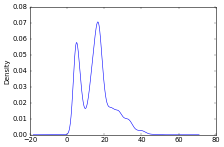

In [98]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.SilverPrice.plot(kind = 'density') 

print('Silver: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.SilverPrice)))
print('Silver:Skewness of normal distribution: {}'.format(stats.skew(dataset.SilverPrice)))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -0.95. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

Oil: Kurtosis of normal distribution: -0.6101518598261646
Oil:Skewness of normal distribution: 0.3972904824258087


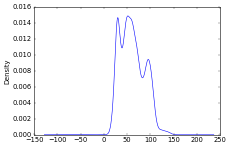

In [99]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset['CrudeOilPrices(WTI)'].plot(kind = 'density') 

print('Oil: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset['CrudeOilPrices(WTI)'])))
print('Oil:Skewness of normal distribution: {}'.format(stats.skew(dataset['CrudeOilPrices(WTI)'])))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -1.16. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

FEDFUNDS: Kurtosis of normal distribution: 0.6508332812328308
FEDFUNDS:Skewness of normal distribution: 1.3371928540747455


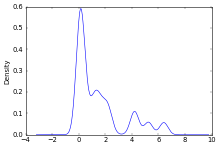

In [100]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.FEDFUNDS.plot(kind = 'density') 

print('FEDFUNDS: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.FEDFUNDS)))
print('FEDFUNDS:Skewness of normal distribution: {}'.format(stats.skew(dataset.FEDFUNDS)))

These two distributions give us some intuition about the distribution of our data. The kurtosis of this dataset is -1.43. Since this value is less than 0, it is considered to be a light-tailed dataset. It has as much data in each tail as it does in the peak. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

count    6437.000000
mean     1016.499759
std       510.296941
min       256.700000
25%       438.250000
50%      1172.000000
75%      1346.850000
max      2061.500000
Name: GoldPrice, dtype: float64

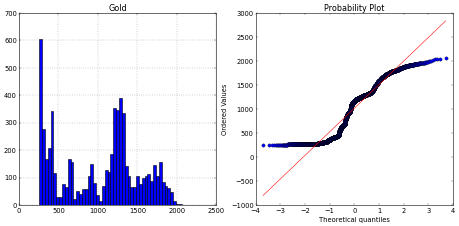

In [101]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['GoldPrice'].hist(bins=50)
plt.title('Gold')
plt.subplot(1,2,2)
stats.probplot(dataset['GoldPrice'], plot=plt);
dataset.GoldPrice.describe().T

Normal probability plot also shows the data is far from normally distributed.

count    6437.000000
mean       15.684237
std         8.546880
min         4.065000
25%         7.360000
50%        15.770000
75%        19.500000
max        48.700000
Name: SilverPrice, dtype: float64

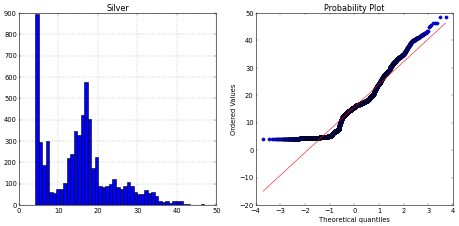

In [102]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['SilverPrice'].hist(bins=50)
plt.title('Silver')
plt.subplot(1,2,2)
stats.probplot(dataset['SilverPrice'], plot=plt);
dataset.SilverPrice.describe().T

Normal probability plot also shows the data is far from normally distributed.

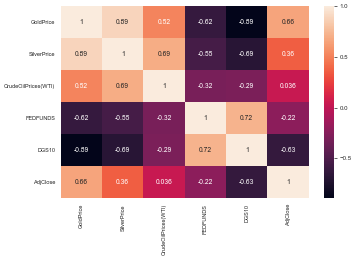

In [103]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
corr = dataset.corr()

fig, ax = plt.subplots()
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [104]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6437 entries, 2000-01-01 to 2022-03-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            6437 non-null   float64
 1   SilverPrice          6437 non-null   float64
 2   CrudeOilPrices(WTI)  6437 non-null   float64
 3   FEDFUNDS             6437 non-null   float64
 4   DGS10                6437 non-null   float64
 5   AdjClose             6437 non-null   float64
dtypes: float64(6)
memory usage: 352.0 KB


In [ ]:
#dataset

### Auto-correlation ###

###### Auto-correlation or serial correlation can be a significant problem in analyzing historical data if we do not know how to look out for it. #######

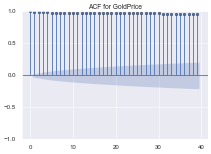

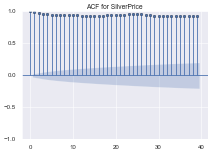

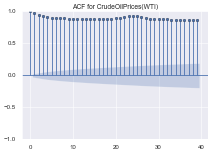

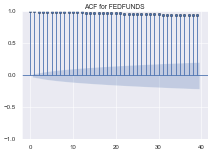

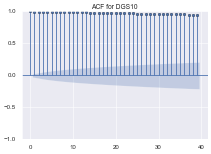

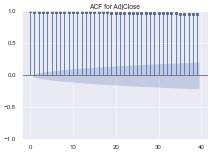

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# plots the autocorrelation plots for each stock's price at 50 lags
for i in dataset:
    series = dataset[i]
    sm.graphics.tsa.plot_acf(series)
    plt.title('ACF for %s' % i)
    plt.show()

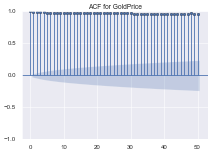

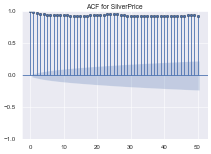

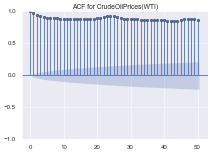

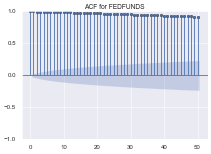

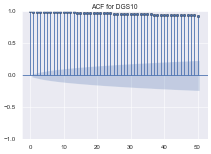

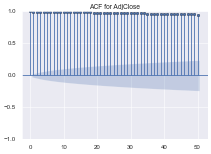

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# plots the autocorrelation plots for each stock's price at 50 lags
for i in dataset:
    sm.graphics.tsa.plot_acf(dataset[i], lags = 50)
    plt.title('ACF for %s' % i)
plt.show()

We see here from the above plots, the auto-correlation of +1 which represents a perfect positive correlation which means, an increase seen in one time series leads to a proportionate increase in the other time series. We definitely need to apply transformation and neutralize this to make the series stationary. It measures linear relationships; even if the auto-correlation is minuscule, there may still be a nonlinear relationship between a time series and a lagged version of itself.

In [107]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6437 entries, 2000-01-01 to 2022-03-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            6437 non-null   float64
 1   SilverPrice          6437 non-null   float64
 2   CrudeOilPrices(WTI)  6437 non-null   float64
 3   FEDFUNDS             6437 non-null   float64
 4   DGS10                6437 non-null   float64
 5   AdjClose             6437 non-null   float64
dtypes: float64(6)
memory usage: 352.0 KB


In [108]:
dataset['AdjClose']

Date
2000-01-01    1455.22
2000-01-02    1455.22
2000-01-03    1455.22
2000-01-04    1399.42
2000-01-05    1402.11
2000-01-06    1403.45
2000-01-07    1441.47
2000-01-08    1441.47
2000-01-09    1441.47
2000-01-10    1457.60
2000-01-11    1438.56
2000-01-12    1432.25
2000-01-13    1449.68
2000-01-14    1465.15
2000-01-17    1465.15
2000-01-18    1455.14
2000-01-19    1455.90
2000-01-20    1445.57
2000-01-21    1441.36
2000-01-24    1401.53
2000-01-25    1410.03
2000-01-26    1404.09
2000-01-27    1398.56
2000-01-28    1360.16
2000-01-31    1394.46
2000-02-01    1409.28
2000-02-02    1409.12
2000-02-03    1424.97
2000-02-04    1424.37
2000-02-05    1424.37
2000-02-06    1424.37
2000-02-07    1424.24
2000-02-08    1441.72
2000-02-09    1411.71
2000-02-10    1416.83
2000-02-11    1387.12
2000-02-14    1389.94
2000-02-15    1402.05
2000-02-16    1387.67
2000-02-17    1388.26
2000-02-18    1346.09
2000-02-21    1346.09
2000-02-22    1352.17
2000-02-23    1360.69
2000-02-24    1353.43
2000-

### Train and Test Data: ###
The VAR model will be fitted on X_train and then used to forecast the next 15 observations. These forecasts will be compared against the actual present in test data.

In [109]:
n_obs=15
X_train, X_test = dataset[0:-n_obs], dataset[-n_obs:]
print(X_train.shape, X_test.shape) 

(6422, 6) (15, 6)


### Transformation: ###

Applying first differencing on training set to make all the series stationary. However, this is an iterative process where we after first differencing, the series may still be non-stationary. We shall have to apply second difference or log transformation to standardize the series in such cases.

In [110]:
transform_data = X_train.diff().dropna()
transform_data.head()


GoldPrice  SilverPrice  CrudeOilPrices(WTI)  FEDFUNDS  DGS10  \
Date                                                                       
2000-01-02       0.00        0.000                 0.00      0.28   0.00   
2000-01-03      10.10       -0.118                 3.43      0.12   0.00   
2000-01-04       0.00        0.000                 0.00      0.17  -0.09   
2000-01-05       0.00        0.000                -5.87      0.25   0.13   
2000-01-06     -20.95       -0.230                 4.35      0.26  -0.05   

            AdjClose  
Date                  
2000-01-02      0.00  
2000-01-03      0.00  
2000-01-04    -55.80  
2000-01-05      2.69  
2000-01-06      1.34

In [111]:
transform_data.describe()

GoldPrice  SilverPrice  CrudeOilPrices(WTI)     FEDFUNDS  \
count  6421.000000  6421.000000          6421.000000  6421.000000   
mean      0.255778     0.003089             0.012842    -0.000818   
std      49.457185     1.540557             6.373977     0.034937   
min    -463.500000   -19.490000           -55.290000    -0.960000   
25%      -6.350000    -0.170000            -0.890000     0.000000   
50%       0.000000     0.000000             0.000000     0.000000   
75%       7.350000     0.180000             1.180000     0.000000   
max     450.500000    11.360000            84.820000     0.280000   

             DGS10     AdjClose  
count  6421.000000  6421.000000  
mean     -0.000720     0.477546  
std       0.052457    20.380918  
min      -0.510000  -324.890000  
25%      -0.030000    -5.610000  
50%       0.000000     0.000000  
75%       0.030000     7.660000  
max       0.290000   230.380000

### Stationarity check ###


In [112]:
!pip install statsmodels 

In [113]:
import statsmodels.tsa.stattools as sm
def augmented_dickey_fuller_statistics(time_series):
    result = sm.adfuller(time_series.values, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [114]:
print('Augmented Dickey-Fuller Test: Gold Price Time Series')
augmented_dickey_fuller_statistics(transform_data['GoldPrice'])
print('Augmented Dickey-Fuller Test: Silver Price Time Series')
augmented_dickey_fuller_statistics(transform_data['SilverPrice'])
print('Augmented Dickey-Fuller Test: CrudeOilPrices(WTI)  Time Series')
augmented_dickey_fuller_statistics(transform_data['CrudeOilPrices(WTI)'])
print('Augmented Dickey-Fuller Test: FEDFUNDS Time Series')
augmented_dickey_fuller_statistics(transform_data['FEDFUNDS'])
print('Augmented Dickey-Fuller Test: DGS10 Time Series')
augmented_dickey_fuller_statistics(transform_data['DGS10'])
print('Augmented Dickey-Fuller Test: AdjClose Time Series')
augmented_dickey_fuller_statistics(transform_data['AdjClose'])

##GoldPrice	SilverPrice	CrudeOilPrices(WTI)	FEDFUNDS	DGS10	AdjClose


Augmented Dickey-Fuller Test: Gold Price Time Series
ADF Statistic: -20.298835
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: Silver Price Time Series
ADF Statistic: -22.128413
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: CrudeOilPrices(WTI)  Time Series
ADF Statistic: -22.918284
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: FEDFUNDS Time Series
ADF Statistic: -15.743493
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: DGS10 Time Series
ADF Statistic: -58.961397
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: AdjClose Time Series
ADF Statistic: -14.937909
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    d = transform_data[transform_data.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Granger’s Causality Test: ###


The formal definition of Granger causality can be explained as, whether past values of x aid in the prediction of yt, conditional on having already accounted for the effects on yt of past values of y (and perhaps of past values of other variables). If they do, the x is said to “Granger cause” y. So, the basis behind VAR is that each of the time series in the system influences each other.
Granger’s causality Tests the null hypothesis that the coefficients of past values in the regression equation is zero. So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis. This has been performed on original data-set.

In [115]:
import statsmodels.tsa.stattools as sm
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = sm.grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset



In [116]:
grangers_causality_matrix(dataset, variables = dataset.columns)
## https://rishi-a.github.io/2020/05/25/granger-causality.html
## https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1
  warnin

GoldPrice_x  SilverPrice_x  CrudeOilPrices(WTI)_x  \
GoldPrice_y                 1.0000         0.0000                 0.0000   
SilverPrice_y               0.0000         1.0000                 0.0000   
CrudeOilPrices(WTI)_y       0.0000         0.0000                 1.0000   
FEDFUNDS_y                  0.4686         0.4693                 0.0237   
DGS10_y                     0.0008         0.0537                 0.0410   
AdjClose_y                  0.1123         0.1128                 0.2284   

                       FEDFUNDS_x  DGS10_x  AdjClose_x  
GoldPrice_y                0.0030   0.0000      0.0005  
SilverPrice_y              0.0000   0.0000      0.0050  
CrudeOilPrices(WTI)_y      0.0000   0.0025      0.0017  
FEDFUNDS_y                 1.0000   0.3397      0.1435  
DGS10_y                    0.1590   1.0000      0.0005  
AdjClose_y                 0.5052   0.0036      1.0000

The row are the response (y) and the columns are the predictor series (x).
* If we take the value 0.0000 in (row 1, column 5), it refers to the p-value of the Granger’s Causality test for InterestRate_x causing Gold_y. The 0.0000 in (row 5, column 1) refers to the p-value of InterestRate_y causing GoldPrice_x and so on.
* We can see that, in the case of Interest and USD variables, we cannot reject null hypothesis e.g. USD & Silver, USD & Oil. 
* Our variables of interest are Gold and Oil here. So, for Gold, all the variables cause but for USD doesn’t causes any effect on Oil.

So, looking at the p-Values, we can assume that, except USD, all the other variables (time series) in the system are interchangeably causing each other. This justifies the VAR modeling approach for this system of multi time-series to forecast.

### VAR model ###

VAR requires stationarity of the series which means the mean to the series do not change over time (we can find this out from the plot drawn next to Augmented Dickey-Fuller Test).


So, I will fit the VAR model on training set and then used the fitted model to forecast the next 15 observations. These forecasts will be compared against the actual present in test data. I have taken the maximum lag (15) to identify the required lags for VAR model.

In [117]:
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

mod = VAR(transform_data)
res = mod.fit(maxlags=15, ic='aic')
print(res.summary())

/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Oct, 2022
Time:                     03:44:58
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    4.33429
Nobs:                     6406.00    HQIC:                   3.95727
Log likelihood:          -66028.2    FPE:                    42.8499
AIC:                      3.75769    Det(Omega_mle):         39.3727
--------------------------------------------------------------------
Results for equation GoldPrice
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.496252         0.596376            0.832           0.405
L1.GoldPrice                   -0.155958         0.020181           -7.728           0.000
L1.SilverPrice  

### Residual plot ###

Residual plot looks normal with constant mean throughout apart from some large fluctuation during 2009, 2011, 2014 etc.

In [118]:
y_fitted = res.fittedvalues
y_fitted

GoldPrice  SilverPrice  CrudeOilPrices(WTI)      FEDFUNDS  \
Date                                                                     
2000-01-19  -14.284059    -0.351963             1.244341 -2.905841e-02   
2000-01-20    6.302917     0.423702            -0.968792 -8.995303e-03   
2000-01-21   -1.606720    -0.349066             1.087764 -5.895930e-04   
2000-01-24    6.986181     0.130672            -1.473453 -2.321560e-02   
2000-01-25   -7.499746    -0.190312             1.063463  7.675657e-03   
2000-01-26  -15.891730    -0.554048            -1.737014  2.614034e-03   
2000-01-27    3.513223     0.123676             1.082782  7.511528e-03   
2000-01-28   -4.837453    -0.167511             0.417943 -3.539762e-03   
2000-01-31   -1.795153    -0.143431             0.424047  2.740979e-03   
2000-02-01   -1.459389    -0.209490            -0.292687  2.865283e-03   
2000-02-02    4.500253     0.113241             0.349458  1.315143e-03   
2000-02-03   -9.145617    -0.278707             0.431943 -2.016364e-03   
2000-02-04    1.163867     0.103557            -1.281799  1.109232e-04   
2000-02-05    2.813079    -0.037127            -1.398682  1.282488e-04   
2000-02-06    5.720839     0.120978             0.503770 -2.751935e-03   
2000-02-07    2.452927     0.020969            -0.040331 -2.954058e-03   
2000-02-08    4.455862     0.055596             0.130474  2.750600e-05   
2000-02-09    5.010397     0.102571             0.024447 -1.043740e-04   
2000-02-10    0.677618    -0.031757             0.308966 -8.162719e-04   
2000-02-11    0.973179    -0.059767            -0.406945 -3.765943e-03   
2000-02-14    7.011964     0.252998            -0.974445  1.047924e-03   
2000-02-15   -1.727037    -0.005462            -0.961372 -8.927520e-04   
2000-02-16   -4.834797    -0.096348            -1.080975 -3.414675e-03   
2000-02-17   -2.783719     0.107470            -0.772615  3.122038e-03   
2000-02-18   -2.683243     0.012877             0.459696  3.773538e-04   
2000-02-21    0.415128     0.065337             0.078918  3.289102e-03   
2000-02-22  -12.912600    -0.427469             0.216292  9.111308e-05   
2000-02-23   -5.804086    -0.113914            -0.735082 -1.389912e-03   
2000-02-24   -7.235123    -0.130584            -0.243639 -1.414990e-03   
2000-02-25   -3.195397    -0.125289            -1.159790 -2.752454e-04   
2000-02-28    2.509027    -0.034204            -0.479376  1.486243e-03   
2000-02-29   -1.083921    -0.140138            -0.033261 -2.334995e-03   
2000-03-01   -1.432677    -0.080207            -0.613741 -3.242302e-03   
2000-03-02    1.907585     0.116387            -0.561512  8.473249e-05   
2000-03-03    6.172400     0.020352             0.266412 -1.475919e-03   
2000-03-04    3.132940     0.049840            -0.163722 -9.305347e-04   
2000-03-05    7.437568     0.025495             0.327400 -1.777358e-03   
2000-03-06    5.539463     0.242907             1.884940 -2.925500e-03   
2000-03-07   10.783747     0.206626             0.559767  2.191369e-03   
2000-03-08    6.326555     0.135965             1.403510  1.064019e-03   
2000-03-09    2.655563     0.004641             0.177884 -5.532654e-04   
2000-03-10   -0.381337    -0.044335             0.268941 -3.025057e-03   
2000-03-11    5.461757     0.112690            -0.956504 -3.346586e-04   
2000-03-13    1.771759     0.056620            -0.608867  3.142665e-04   
2000-03-14    3.393128    -0.034685            -0.990518  1.091831e-03   
2000-03-15    0.347105    -0.114782            -0.643436  4.414947e-05   
2000-03-16   -0.699835    -0.020720            -0.666789 -2.051014e-03   
2000-03-17    0.619529     0.080280            -0.369924 -2.876219e-03   
2000-03-20    6.317857     0.298749            -0.426301 -3.457936e-04   
2000-03-21   -1.821005    -0.031718             0.351816  9.141098e-04   
2000-03-22    7.216580     0.192848             1.269450 -1.082892e-03   
2000-03-23    7.451729     0.196869             1.051871 -1.776298e-03   
2000-03-24    5.9

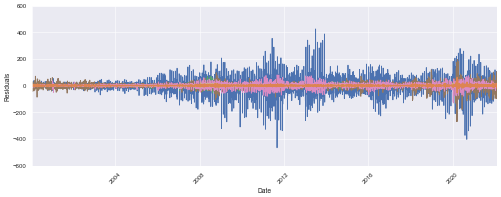

In [119]:
y_fitted = res.fittedvalues
residuals = res.resid
plt.figure(figsize = (15,5))
plt.plot(residuals, label='resid')
plt.plot(y_fitted, label='VAR prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.grid(True)

### Durbin-Watson Statistic ###
The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern.

###### A stock price displaying positive auto-correlation would indicate that the price yesterday has a positive correlation on the price today — so if the stock fell yesterday, it is also likely that it falls today. A stock that has a negative auto-correlation, on the other hand, has a negative influence on itself over time — so that if it fell yesterday, there is a greater likelihood it will rise today. ######

In [120]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(res.resid)
for col,val in zip(transform_data.columns, out):
    print((col), ":", round(val,2))
    

GoldPrice : 2.01
SilverPrice : 2.01
CrudeOilPrices(WTI) : 2.0
FEDFUNDS : 2.0
DGS10 : 2.0
AdjClose : 2.0


#### There is no auto-correlation (2.0) exist; so, we can proceed with the forecast. ####

#### Prediction: #### 
In order to forecast, the VAR model expects up to the lag order number of observations from the past data. This is because, the terms in the VAR model are essentially the lags of the various time series in the data-set, so we need to provide as many of the previous values as indicated by the lag order used by the model.

In [121]:
# Get the lag order
lag_order = res.k_ar
print(lag_order)
# Input data for forecasting
input_data = transform_data.values[-lag_order:]
print(input_data)
# forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

15
[[ 6.7000e+00  8.6000e-01  1.4200e+00  0.0000e+00 -4.0000e-02 -4.4350e+01]
 [ 1.9200e+01  4.5000e-01 -5.5000e-01  0.0000e+00  0.0000e+00 -5.0030e+01]
 [-2.4500e+00  9.5000e-02 -1.1300e+00  0.0000e+00 -8.0000e-02 -8.4790e+01]
 [ 4.0000e+00 -2.5500e-01 -6.8000e-01  0.0000e+00  0.0000e+00  1.2190e+01]
 [-2.6000e+00 -4.0000e-01  2.1300e+00  0.0000e+00  3.0000e-02 -5.3680e+01]
 [ 9.5500e+00  1.9500e-01  1.7200e+00  0.0000e+00  7.0000e-02 -6.5200e+00]
 [-2.9700e+01 -6.9000e-01 -7.2000e-01  0.0000e+00 -4.0000e-02 -2.3420e+01]
 [-2.5300e+01 -6.7000e-01  6.0000e-02  0.0000e+00 -3.0000e-02  1.0534e+02]
 [ 4.0000e-01 -5.0000e-03  1.4900e+00  0.0000e+00  1.0000e-02  8.3700e+01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  2.0000e-02  3.0990e+01]
 [ 1.1400e+01  2.8500e-01 -1.0000e+00  0.0000e+00 -3.0000e-02  4.2840e+01]
 [ 1.2400e+02  2.2950e+00  2.2580e+01  0.0000e+00  4.0000e-02 -1.1194e+02]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.1000e-01  2.3090e+01]
 [ 0.0000e+00  0.0000e

In [122]:
print(X_test.index)

DatetimeIndex(['2022-02-09', '2022-02-10', '2022-02-11', '2022-02-14',
               '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18',
               '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24',
               '2022-02-25', '2022-02-28', '2022-03-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


#### Invert the transformation: ####

The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, we need to de-difference it.
The way to convert the differencing is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number.
This process can be reversed by adding the observation at the prior time step to the difference value. inverted(ts) = differenced(ts) + observation(ts-1)

In [123]:
# inverting transformation
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
        return forecast

output = invert_transformation(X_train, pred)

## https://stackoverflow.com/questions/20461165/how-to-convert-index-of-a-pandas-dataframe-into-a-column
output['Date'] = output.index

print(output)

            GoldPrice_pred  SilverPrice_pred  CrudeOilPrices(WTI)_pred  \
Date                                                                     
2022-02-09     1906.115956         -0.429477                 -3.788926   
2022-02-10     1897.261499         -0.141129                 -4.196226   
2022-02-11     1886.814058         -0.062259                 -1.660219   
2022-02-14     1886.578217          0.209601                 -0.512130   
2022-02-15     1887.221144          0.334036                 -1.921058   
2022-02-16     1886.003486          0.040210                  0.423540   
2022-02-17     1886.643235          0.070296                 -0.906731   
2022-02-18     1876.654208         -0.381462                  0.518134   
2022-02-21     1868.722753         -0.375953                 -0.213444   
2022-02-22     1870.224701          0.137257                  1.700407   
2022-02-23     1868.404420         -0.168034                 -0.983071   
2022-02-24     1873.743045          0.

In [124]:
output.columns

Index(['GoldPrice_pred', 'SilverPrice_pred', 'CrudeOilPrices(WTI)_pred',
       'FEDFUNDS_pred', 'DGS10_pred', 'AdjClose_pred', 'Date'],
      dtype='object')

In [125]:
output.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2022-02-09 to 2022-03-01
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   GoldPrice_pred            15 non-null     float64       
 1   SilverPrice_pred          15 non-null     float64       
 2   CrudeOilPrices(WTI)_pred  15 non-null     float64       
 3   FEDFUNDS_pred             15 non-null     float64       
 4   DGS10_pred                15 non-null     float64       
 5   AdjClose_pred             15 non-null     float64       
 6   Date                      15 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 960.0 bytes


In [126]:
print(output['GoldPrice_pred'])

Date
2022-02-09    1906.115956
2022-02-10    1897.261499
2022-02-11    1886.814058
2022-02-14    1886.578217
2022-02-15    1887.221144
2022-02-16    1886.003486
2022-02-17    1886.643235
2022-02-18    1876.654208
2022-02-21    1868.722753
2022-02-22    1870.224701
2022-02-23    1868.404420
2022-02-24    1873.743045
2022-02-25    1878.651937
2022-02-28    1879.788626
2022-03-01    1881.909359
Name: GoldPrice_pred, dtype: float64


In [127]:
output

GoldPrice_pred  SilverPrice_pred  CrudeOilPrices(WTI)_pred  \
Date                                                                     
2022-02-09     1906.115956         -0.429477                 -3.788926   
2022-02-10     1897.261499         -0.141129                 -4.196226   
2022-02-11     1886.814058         -0.062259                 -1.660219   
2022-02-14     1886.578217          0.209601                 -0.512130   
2022-02-15     1887.221144          0.334036                 -1.921058   
2022-02-16     1886.003486          0.040210                  0.423540   
2022-02-17     1886.643235          0.070296                 -0.906731   
2022-02-18     1876.654208         -0.381462                  0.518134   
2022-02-21     1868.722753         -0.375953                 -0.213444   
2022-02-22     1870.224701          0.137257                  1.700407   
2022-02-23     1868.404420         -0.168034                 -0.983071   
2022-02-24     1873.743045          0.004498                 -0.260193   
2022-02-25     1878.651937          0.033366                  0.904262   
2022-02-28     1879.788626          0.036267                  0.855967   
2022-03-01     1881.909359         -0.003215                  0.677367   

            FEDFUNDS_pred  DGS10_pred  AdjClose_pred       Date  
Date                                                             
2022-02-09      -0.005968   -0.001512      -5.103303 2022-02-09  
2022-02-10      -0.005673   -0.004633       1.508150 2022-02-10  
2022-02-11      -0.004907    0.004108       2.996689 2022-02-11  
2022-02-14      -0.008470    0.019878      -1.106965 2022-02-14  
2022-02-15      -0.004791    0.002195       8.708654 2022-02-15  
2022-02-16      -0.000921   -0.002545      -5.811586 2022-02-16  
2022-02-17       0.001264   -0.007578       7.338517 2022-02-17  
2022-02-18       0.006956   -0.007608      -6.618136 2022-02-18  
2022-02-21       0.003929   -0.002232       0.837439 2022-02-21  
2022-02-22       0.000197    0.001155       0.848258 2022-02-22  
2022-02-23      -0.000158    0.010419       3.007284 2022-02-23  
2022-02-24      -0.003372    0.006151      -0.571102 2022-02-24  
2022-02-25      -0.001314   -0.001521      -0.222812 2022-02-25  
2022-02-28       0.000204    0.000382       1.588591 2022-02-28  
2022-03-01       0.001375   -0.002837      -0.454178 2022-03-01

In [129]:
#combining predicted and real data set
combine = pd.concat([output['GoldPrice_pred'], X_test['GoldPrice']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.GoldPrice_pred /row.GoldPrice *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Date', ascending=False)

print(combine)

         Date  GoldPrice_pred  GoldPrice accuracy
14 2022-03-01         1881.91    1903.30   98.88%
13 2022-02-28         1879.79    1903.30   98.76%
12 2022-02-25         1878.65    1912.15   98.25%
11 2022-02-24         1873.74    1968.35   95.19%
10 2022-02-23         1868.40    1895.70   98.56%
9  2022-02-22         1870.22    1895.00   98.69%
8  2022-02-21         1868.72    1895.45   98.59%
7  2022-02-18         1876.65    1886.95   99.45%
6  2022-02-17         1886.64    1886.55  100.00%
5  2022-02-16         1886.00    1854.40  101.70%
4  2022-02-15         1887.22    1855.10  101.73%
3  2022-02-14         1886.58    1855.80  101.66%
2  2022-02-11         1886.81    1926.00   97.97%
1  2022-02-10         1897.26    1926.00   98.51%
0  2022-02-09         1906.12    1926.00   98.97%


In [128]:
# old
#combining predicted and real data set
combine = pd.concat([output['GoldPrice_pred'], X_test['GoldPrice']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.GoldPrice_pred /row.GoldPrice *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Date', ascending=False)

print(combine)

         Date  GoldPrice_pred  GoldPrice accuracy
14 2022-03-01         1881.91    1903.30   98.88%
13 2022-02-28         1879.79    1903.30   98.76%
12 2022-02-25         1878.65    1912.15   98.25%
11 2022-02-24         1873.74    1968.35   95.19%
10 2022-02-23         1868.40    1895.70   98.56%
9  2022-02-22         1870.22    1895.00   98.69%
8  2022-02-21         1868.72    1895.45   98.59%
7  2022-02-18         1876.65    1886.95   99.45%
6  2022-02-17         1886.64    1886.55  100.00%
5  2022-02-16         1886.00    1854.40  101.70%
4  2022-02-15         1887.22    1855.10  101.73%
3  2022-02-14         1886.58    1855.80  101.66%
2  2022-02-11         1886.81    1926.00   97.97%
1  2022-02-10         1897.26    1926.00   98.51%
0  2022-02-09         1906.12    1926.00   98.97%


#### Evaluation: #### 
To evaluate the forecasts, a comprehensive set of metrics, such as the MAPE, ME, MAE, MPE and RMSE can be computed. We have computed some of these as below.

In [130]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
#Forecast bias
forecast_errors = [combine['GoldPrice'][i]- combine['GoldPrice_pred'][i] for i in range(len(combine['GoldPrice']))]
bias = sum(forecast_errors) * 1.0/len(combine['GoldPrice'])

print('Bias: %f' % bias) 
print('Mean absolute error:', mean_absolute_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values))
print('Mean squared error:', mean_squared_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values))
print('Root mean squared error:', math.sqrt(mean_squared_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values)))

Bias: 17.022667
Mean absolute error: 29.634666666666664
Mean squared error: 1266.5469733333318
Root mean squared error: 35.58857925421204


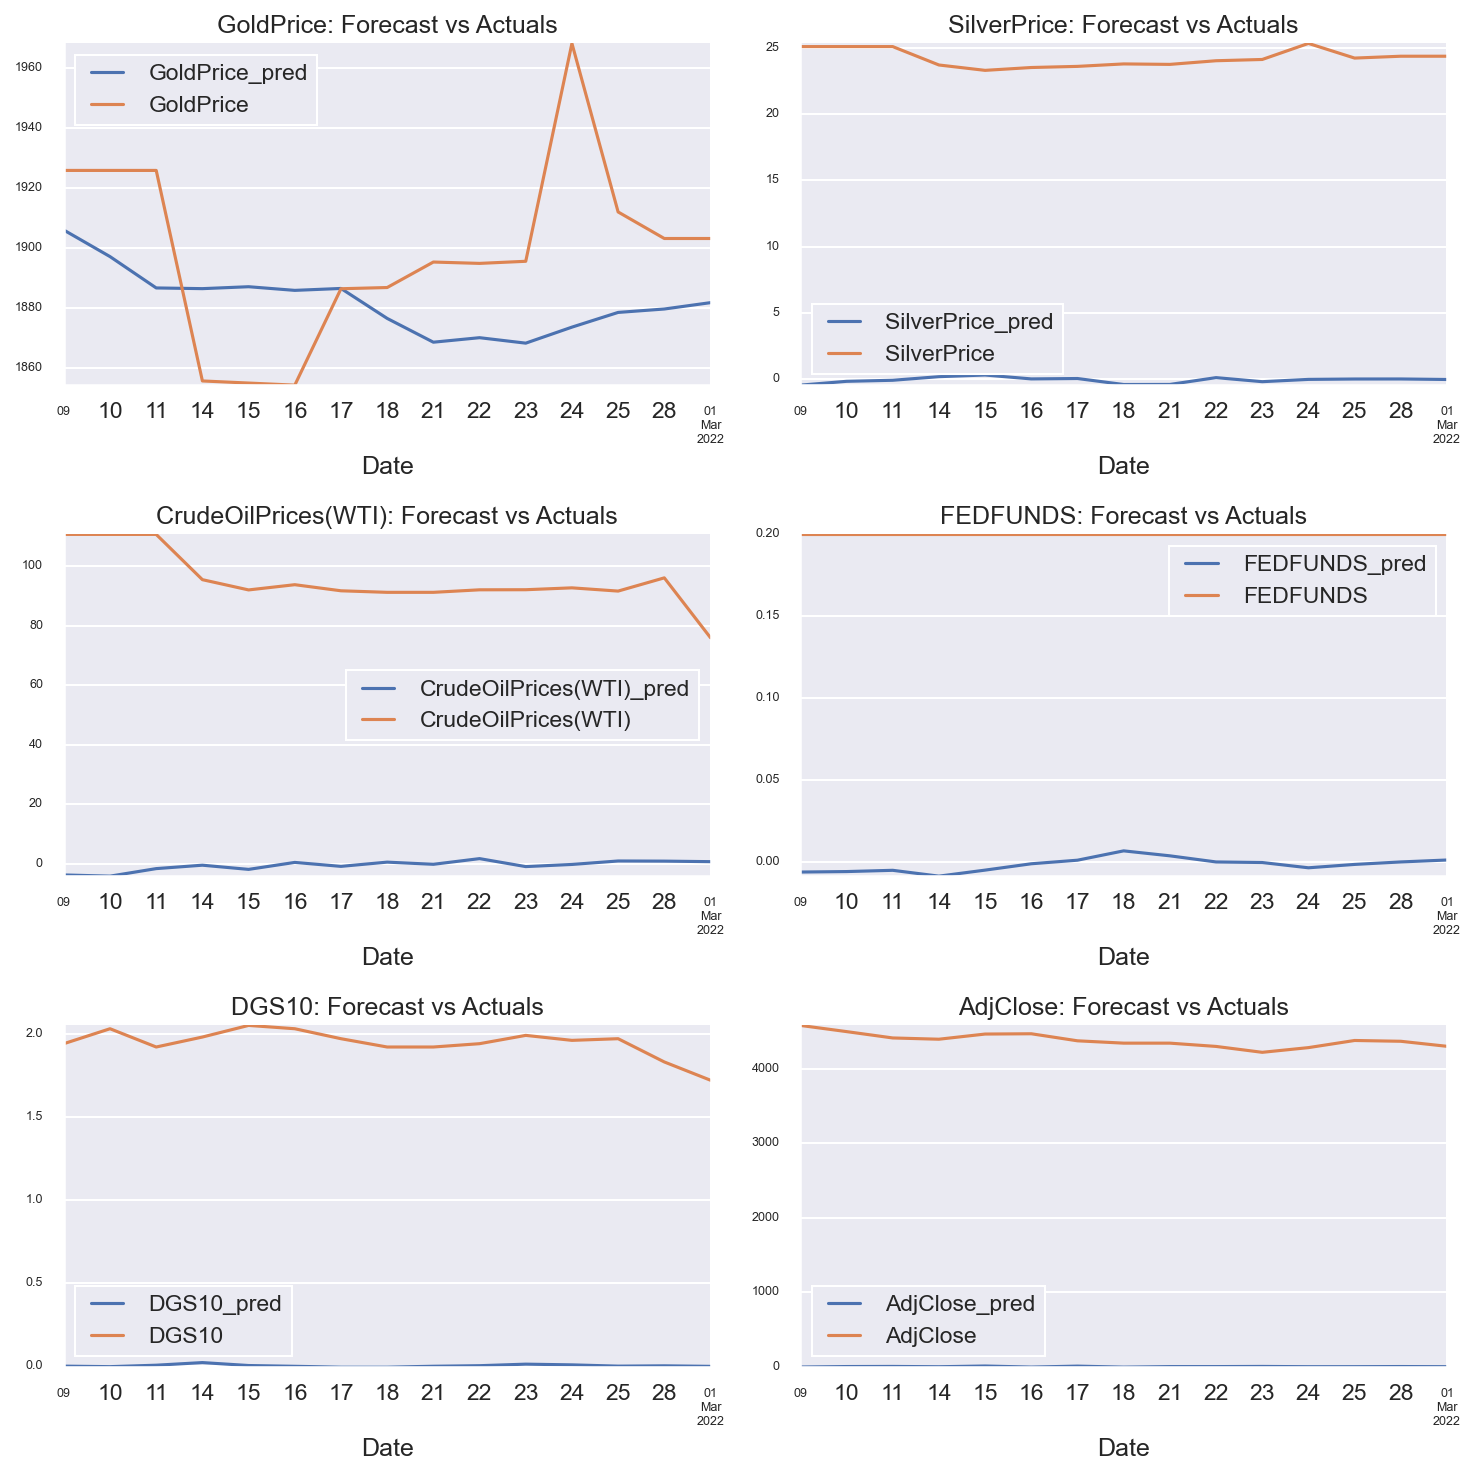

In [131]:
## https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

fig, axes = plt.subplots(nrows=int(len(dataset.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(dataset.columns, axes.flatten())):
    output[col+'_pred'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    X_test[col][-n_obs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### Summary #### 

The VAR model is a popular tool for the purpose of predicting joint dynamics of multiple time series based on linear functions of past observations. More analysis e.g. impulse response (IRF) and forecast error variance decomposition (FEVD) can also be done along-with VAR to for assessing the impacts of shock from one asset on another to assess the impacts of shock from one asset on another. However, I will keep this simple here for easy understanding. In real-life business case, we should do multiple models with different approach to do the comparative analysis before zeroed down on one or a hybrid model.


### Prophet In Action ###

In [132]:
# Time Series
# https://dev.socrata.com/blog/2019/10/07/time-series-analysis-with-jupyter-notebooks-and-socrata.html

# Data Source
# Building Permits
# https://data.seattle.gov/Permitting/Building-Permits/76t5-zqzr

dataset.info()
df3=dataset

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6437 entries, 2000-01-01 to 2022-03-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            6437 non-null   float64
 1   SilverPrice          6437 non-null   float64
 2   CrudeOilPrices(WTI)  6437 non-null   float64
 3   FEDFUNDS             6437 non-null   float64
 4   DGS10                6437 non-null   float64
 5   AdjClose             6437 non-null   float64
dtypes: float64(6)
memory usage: 352.0 KB


In [133]:
dataset.index

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-28', '2022-03-01'],
              dtype='datetime64[ns]', name='Date', length=6437, freq=None)

In [136]:
from fbprophet import Prophet
model = Prophet()
train_df = df3.rename(columns={"GoldPrice":'y'})
train_df["ds"] = train_df.index
model.fit(train_df)

     |████████████████████████████████| 64 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 20.6 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 17.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 52.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 59.3 MB/s eta 0:00:01
     |████████████████████████████████| 35.3 MB 56.3 MB/s eta 0:00:01
     |████████████████████████████████| 197 kB 105.9 MB/s eta 0:00:01
     |████████████████████████████████| 91 kB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 33.3 MB/s  eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /Users/spartan/opt/anaconda3/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/3m/l7h25c9d0mj46kv1xkbdmb0c0000gr/T/pip-install-d5v7_2hs/fbprophet_03d8b8e9a15d4167bf647194e0e84695/setup.py'"'"'; __file__='"'"'/private/var/folders/3m/l7h25c9d0mj46kv1xkbdmb0c0000gr/T/pip-i

ModuleNotFoundError: No module named 'fbprophet'

In [135]:
pd.plotting.register_matplotlib_converters()

# We want to forecast over the next 5 months
future = model.make_future_dataframe(30, freq='D', include_history=True)
forecast = model.predict(future)
model.plot(forecast)

NameError: name 'model' is not defined

In [ ]:
forecast